### PAR-2 RING SEC-MALS (Part 1)

Context:
- SEC-MALS traces for PAR-2 RING at a range of input concentrations
- Additionally a single data point for L109R (we were unable to purify enough for higher concentrations)

Results:
- Clear evidence for concentration-dependent dimerisation
- L109R appears mainly monomeric

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import nb_setup, raw_data_path

nb_setup()
os.makedirs("Figs", exist_ok=True)
os.makedirs("../../../data/EMBO_source_data", exist_ok=True)

%matplotlib inline

### Import data

In [2]:
root_path = raw_data_path + "SEC MALS/Experiment1/Analysis2/csv/"

csv_wt_500ugml = pd.read_csv(root_path + "20220128_Par2Ring_WT_S75_500ugml.csv")
csv_wt_750ugml = pd.read_csv(root_path + "20220128_Par2Ring_WT_S75_750ugml.csv")
csv_wt_2000ugml = pd.read_csv(root_path + "20210927_Par2Ring_WT_S75_2mgml.csv")
csv_wt_5000ugml = pd.read_csv(root_path + "20210924_Par2Ring_WT_S75_5mgml.csv")
csv_wt_10000ugml = pd.read_csv(root_path + "20210924_Par2Ring_WT_S75_10mgml.csv")

csv_L109R_750ugml = pd.read_csv(root_path + "20210924_Par2Ring_L109R_S75.csv")

### Prepare data for plotting

In [3]:
def prepare_dataframe(csv, xlim=[10.5, 13.5], time_multiplier=0.5):
    # Prepare dataframe
    df = csv.copy()
    df.columns = ["Time", "RIU", "Molar mass"]
    df.replace(" ", "NaN", inplace=True)
    df["Molar mass"] = df["Molar mass"].astype(float)

    # Create retention volume column
    df["Retention volume"] = df.Time * time_multiplier

    # Filter rows based on xlim
    df = df[
        np.logical_and(
            df["Retention volume"] > xlim[0], df["Retention volume"] < xlim[1]
        )
    ]

    # Calculate region of interest for molecular weight measurements
    max_riu_within_xlim = np.max(df.RIU)
    threshold = 0.8 * max_riu_within_xlim
    mol_weight_limits = df["Retention volume"].values[
        np.abs(np.diff(np.sign(df.RIU.values - threshold), prepend=0)) == 2
    ]
    mol_weight_bool = np.logical_and(
        df["Retention volume"] > mol_weight_limits[0],
        df["Retention volume"] < mol_weight_limits[1],
    )
    df.loc[~mol_weight_bool, "Molar mass"] = np.nan

    return df


df_wt_500ugml = prepare_dataframe(csv_wt_500ugml)
df_wt_750ugml = prepare_dataframe(csv_wt_750ugml)
df_wt_2000ugml = prepare_dataframe(csv_wt_2000ugml)
df_wt_5000ugml = prepare_dataframe(csv_wt_5000ugml)
df_wt_10000ugml = prepare_dataframe(csv_wt_10000ugml)
df_L109R_750ugml = prepare_dataframe(csv_L109R_750ugml)

### Plotting function

In [4]:
def create_fig(
    df,
    ylim1=None,
    ylim2=[0, 25],
    xlim=[10.5, 13.5],
    color="tab:blue",
    fig=None,
    ax1=None,
    ax2=None,
):
    # Create figure
    if fig is None:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

    # Plot data
    ax1.plot(df["Retention volume"], df.RIU * 10000, c=color, linewidth=1)
    ax2.plot(
        df["Retention volume"],
        df["Molar mass"] / 1000,
        c=color,
        linestyle="dotted",
    )

    # Add monomer/dimer
    ax2.axhline(9.23474, c="k", linestyle="--", linewidth=0.5, zorder=0)
    ax2.axhline(9.23474 * 2, c="k", linestyle="--", linewidth=0.5, zorder=0)
    ax2.text(
        13.4,
        9.5,
        "Monomer",
        horizontalalignment="right",
        verticalalignment="bottom",
        fontsize=8,
    )
    ax2.text(
        13.4,
        18.7,
        "Dimer",
        horizontalalignment="right",
        verticalalignment="bottom",
        fontsize=8,
    )

    # Set lims
    if ylim1 is not None:
        ax1.set_ylim(*ylim1)
    else:
        ax1.set_ylim(
            [
                0,
                1.1
                * np.max(
                    df.RIU.values[
                        np.logical_and(
                            df["Retention volume"] > xlim[0],
                            df["Retention volume"] < xlim[1],
                        )
                    ]
                    * 10000
                ),
            ]
        )
    ax2.set_ylim(*ylim2)
    ax1.set_xlim(*xlim)

    # Finalise fig
    ax1.set_xlabel("Retention volume (ml)", fontsize=9)
    ax1.set_ylabel(f"Refractive index (x {r'$10^4$'})", fontsize=9)
    ax2.set_ylabel("Molar mass (kDa)", fontsize=9)
    ax1.tick_params(axis="both", labelsize=8)
    ax2.tick_params(axis="both", labelsize=8)
    fig.set_size_inches(4, 3)
    fig.tight_layout()

    return fig, ax1, ax2

### Plot: WT

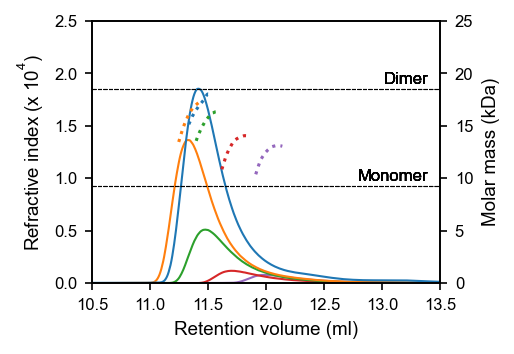

In [5]:
# Create figure
fig, ax1, ax2 = create_fig(df_wt_500ugml, color="tab:purple")
fig, ax1, ax2 = create_fig(df_wt_750ugml, fig=fig, ax1=ax1, ax2=ax2, color="tab:red")
fig, ax1, ax2 = create_fig(df_wt_2000ugml, fig=fig, ax1=ax1, ax2=ax2, color="tab:green")
fig, ax1, ax2 = create_fig(
    df_wt_5000ugml, fig=fig, ax1=ax1, ax2=ax2, color="tab:orange"
)
fig, ax1, ax2 = create_fig(df_wt_10000ugml, fig=fig, ax1=ax1, ax2=ax2, color="tab:blue")

# Format figure
ax1.set_ylim(top=2.5)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2, top=0.9)

# Save
fig.savefig("Figs/wt_titration.png", dpi=600, transparent=True)
fig.savefig("Figs/wt_titration.pdf", transparent=True)

# SourceData
os.makedirs("../../../data/EMBO_source_data/2F", exist_ok=True)
df_wt_500ugml.to_csv("../../../data/EMBO_source_data/2F/wt_500ugml.csv", index=False)
df_wt_750ugml.to_csv("../../../data/EMBO_source_data/2F/wt_750ugml.csv", index=False)
df_wt_2000ugml.to_csv("../../../data/EMBO_source_data/2F/wt_2000ugml.csv", index=False)
df_wt_5000ugml.to_csv("../../../data/EMBO_source_data/2F/wt_5000ugml.csv", index=False)
df_wt_10000ugml.to_csv(
    "../../../data/EMBO_source_data/2F/wt_10000ugml.csv", index=False
)

### Plot: L109R

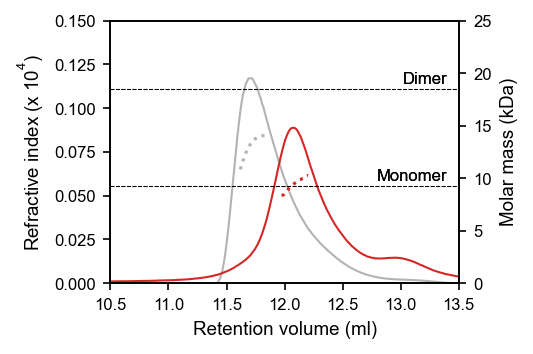

In [6]:
# Create figure
fig, ax1, ax2 = create_fig(df_wt_750ugml, color="0.7")
fig, ax1, ax2 = create_fig(
    df_L109R_750ugml, fig=fig, ax1=ax1, ax2=ax2, ylim1=[0, 0.1], color="tab:red"
)

# Format figure
fig.set_size_inches(3.8, 2.8)
ax1.set_ylim(top=0.15)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2, top=0.9)

# Save
fig.savefig("Figs/L109R.png", dpi=600, transparent=True)
fig.savefig("Figs/L109R.pdf", transparent=True)

# SourceData
os.makedirs("../../../data/EMBO_source_data/2G", exist_ok=True)
df_wt_750ugml.to_csv("../../../data/EMBO_source_data/2G/wt_750ugml.csv", index=False)
df_L109R_750ugml.to_csv(
    "../../../data/EMBO_source_data/2G/L109R_750ugml.csv", index=False
)